In [2]:
from __future__ import division, print_function, absolute_import

import sys
import numpy as np

from scipy import linalg
from scipy._lib.six import callable, get_method_function, get_function_code
from scipy.special import xlogy

In [4]:
"""
rbf - Radial basis functions for interpolation/smoothing scattered Nd data.
"""
__all__ = ['Rbf'] # export RBF class

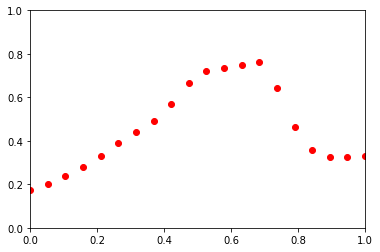

In [34]:
# # "Examples Usange"
# from scipy.interpolate import Rbf
# import matplotlib.pyplot as plt
# x, y, z, d = np.random.rand(4, 50)
# rbfi = Rbf(x, y, z, d, function='linear')  # radial basis function interpolator instance
# xi = yi = zi = np.linspace(0, 1, 20)
# di = rbfi(xi, yi, zi)   # interpolated values
# di.shape # (20,)
# plt.plot(xi, di, 'ro')
# plt.axis([0, 1, 0, 1])
# plt.show()

In [25]:
"""
Rbf(*args)
A class for radial basis function approximation/interpolation of
n-dimensional scattered data.
Parameters
----------
*args : arrays
    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes
    and d is the array of values at the nodes
function : str or callable, optional
    The radial basis function, based on the radius, r, given by the norm
    (default is Euclidean distance); the default is 'multiquadric'::
        'multiquadric': sqrt((r/self.epsilon)**2 + 1)
        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
        'gaussian': exp(-(r/self.epsilon)**2)
        'linear': r
        'cubic': r**3
        'quintic': r**5
        'thin_plate': r**2 * log(r)
    If callable, then it must take 2 arguments (self, r).  The epsilon
    parameter will be available as self.epsilon.  Other keyword
    arguments passed in will be available as well.
epsilon : float, optional
    Adjustable constant for gaussian or multiquadrics functions
    - defaults to approximate average distance between nodes (which is
    a good start).
smooth : float, optional
    Values greater than zero increase the smoothness of the
    approximation.  0 is for interpolation (default), the function will
    always go through the nodal points in this case.
norm : callable, optional
    A function that returns the 'distance' between two points, with
    inputs as arrays of positions (x, y, z, ...), and an output as an
    array of distance.  E.g, the default::
        def euclidean_norm(x1, x2):
            return sqrt( ((x1 - x2)**2).sum(axis=0) )
    which is called with x1=x1[ndims,newaxis,:] and
    x2=x2[ndims,:,newaxis] such that the result is a matrix of the
    distances from each point in x1 to each point in x2.

"""

"\nRbf(*args)\nA class for radial basis function approximation/interpolation of\nn-dimensional scattered data.\nParameters\n----------\n*args : arrays\n    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes\n    and d is the array of values at the nodes\nfunction : str or callable, optional\n    The radial basis function, based on the radius, r, given by the norm\n    (default is Euclidean distance); the default is 'multiquadric'::\n        'multiquadric': sqrt((r/self.epsilon)**2 + 1)\n        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)\n        'gaussian': exp(-(r/self.epsilon)**2)\n        'linear': r\n        'cubic': r**3\n        'quintic': r**5\n        'thin_plate': r**2 * log(r)\n    If callable, then it must take 2 arguments (self, r).  The epsilon\n    parameter will be available as self.epsilon.  Other keyword\n    arguments passed in will be available as well.\nepsilon : float, optional\n    Adjustable constant for gaussian or multiquadrics functions\n  

In [109]:
class CustomRbf(object):
    def _euclidean_norm(self, x1, x2):
        return np.sqrt(((x1 - x2)**2).sum(axis=0))

    def _h_linear(self, r):
        return r
    
    # Setup self._function and do smoke test on initial r
    def _init_function(self, r):
        self.function = self.function.lower()
        
        func_name = "_h_" + self.function
        self._function = getattr(self, func_name)
        a0 = self._function(r) # (50, 50)
        if a0.shape != r.shape:
            raise ValueError("Callable must take array and return array of the same shape")
        return a0

    def __init__(self, *args, **kwargs):
        # args[:-1] => except last element, d
        self.xi = np.asarray([np.asarray(a, dtype=np.float_).flatten() for a in args[:-1]])
        self.N = self.xi.shape[-1]
        self.di = np.asarray(args[-1]).flatten()

        if not all([x.size == self.di.size for x in self.xi]):
            raise ValueError("All arrays must be equal length.")

        self.norm = kwargs.pop('norm', self._euclidean_norm)
        r = self._call_norm(self.xi, self.xi)
        self.epsilon = kwargs.pop('epsilon', None)
        if self.epsilon is None:
            # default epsilon is the "the average distance between nodes" based on a bounding hypercube
            dim = self.xi.shape[0]
            ximax = np.amax(self.xi, axis=1) # ex) [ 0.95796556  0.97210597  0.98511454]
            ximin = np.amin(self.xi, axis=1) # ex) [ 0.0021079   0.00774162  0.00727649]
            edges = ximax-ximin # ex) [ 0.95585766  0.96436435  0.97783805]
            # nonzero => 요소들 중 0이 아닌 값들의 index 들을 반환해 주는 함수
            # 해당 edges는 모든 요소가 0이 아니므로 위의 edges와 아래의 edges는 같다.
            edges = edges[np.nonzero(edges)] 
            self.epsilon = np.power(np.prod(edges)/self.N, 1.0/edges.size)
        self.smooth = kwargs.pop('smooth', 0.0)

        self.function = kwargs.pop('function', 'multiquadric')
        print(self.function) # linear

        # attach anything left in kwargs to self for use by any user-callable function or 
        # to save on the object returned. 
        for item, value in kwargs.items(): 
            setattr(self, item, value) # Not enter here!

        self.A = self._init_function(r) - np.eye(self.N)*self.smooth # r.shape (50, 50)
        self.nodes = linalg.solve(self.A, self.di)

    def _call_norm(self, x1, x2):
        if len(x1.shape) == 1:
            x1 = x1[np.newaxis, :]
        if len(x2.shape) == 1:
            x2 = x2[np.newaxis, :]
        x1 = x1[..., :, np.newaxis] # (3, 50) -> (3, 50, 1)
        x2 = x2[..., np.newaxis, :] # (3, 50) -> (3, 1, 50)
        return self.norm(x1, x2) # (50, 50)

    def __call__(self, *args):
        args = [np.asarray(x) for x in args]
        if not all([x.shape == y.shape for x in args for y in args]):
            raise ValueError("Array lengths must be equal")
        shp = args[0].shape
        xa = np.asarray([a.flatten() for a in args], dtype=np.float_)
        r = self._call_norm(xa, self.xi)
        return np.dot(self._function(r), self.nodes).reshape(shp)

In [111]:
# "Examples Usange"
import matplotlib.pyplot as plt
x, y, z, d = np.random.rand(4, 50)
rbfi = CustomRbf(x, y, z, d, function='linear')  # radial basis function interpolator instance
# xi = yi = zi = np.linspace(0, 1, 20)
# di = rbfi(xi, yi, zi)   # interpolated values
# di.shape # (20,)
# plt.plot(xi, di, 'ro')
# plt.axis([0, 1, 0, 1])
# plt.show()

linear
(50, 50)
